In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt

In [2]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

print(xgboost.__version__)

1.5.2


In [3]:
def xgbr_gridSearchCV_best_params(learning_rate = [0.02], max_depth = [1], min_child_weight = [1], subsample = [0.8], colsample_bytree = [0.5], n_estimators = [1000], gamma = [1], cv = 3, n_jobs = 3, verbose = False):
    
    xgb_r = XGBRegressor()
    parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
                  #'objective':['reg:linear'],
                  #'learning_rate': learning_rate, #so called `eta` value
                  'max_depth': max_depth #,
                  #'min_child_weight': min_child_weight,
                  #'subsample': subsample,
                  #'colsample_bytree': colsample_bytree,
                  #'n_estimators': n_estimators, 
                  #'gamma' : gamma
                }

    xgb_r_grid = GridSearchCV(xgb_r,
                            parameters,
                            cv = cv,
                            n_jobs = n_jobs,
                            verbose=verbose)

    xgb_r_grid.fit(X_train, y_train)

    #print(xgb_r_grid.best_score_)
    #print(xgb_r_grid.best_params_)
    
    return {'best_score' : xgb_r_grid.best_score_, 'best_params' : xgb_r_grid.best_params_}

In [4]:
def XGBRegressor_fit(colsample_bytree=0.5, learning_rate=0.02, max_depth=1, min_child_weight=1, n_estimators=1000, subsample=0.8, gamma = 1, verbose=False):
    
    xgb_r = XGBRegressor(
        #objective= 'reg:linear', 
        #colsample_bytree = colsample_bytree, 
        learning_rate = learning_rate, 
        max_depth = max_depth, 
        #min_child_weight = min_child_weight, 
        n_estimators = n_estimators #,
        #subsample = subsample, 
        #gamma = gamma
        )




    # Fitting the model
    eval_set = [(X_test, y_test)]
    xgb_r.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=20, verbose=verbose)

    # Predict the model
    pred = xgb_r.predict(X_test)

    # RMSE Computation
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    #print("RMSE : % f" %(rmse))

    #print("score train :",xgb_r.score(X_train, y_train))
    #print("score test :", xgb_r.score(X_test, y_test))
    
    return {'xgb_r' : xgb_r, 'rmse' : rmse, 'score_train' : xgb_r.score(X_train, y_train), 'score_test' : xgb_r.score(X_test, y_test)}

In [5]:
def label_encode_to_int(df):
    
    lab = LabelEncoder()

    df_object = df.select_dtypes(include='object')    
    
    for c in df_object.columns:
    
        df[c] = lab.fit_transform(df[c])

        #df[c] = df[c].fillna(df[c].mode()[0])
        df[c] = df[c].fillna(-1)

        df[c] = df[c].astype(int)
    
    return df

In [6]:
df_train = pd.read_csv("./dataset/train.csv")
df_train_Id = df_train[['Id']]
df_train.drop(['Id'], axis = 1, inplace=True)
df_train.shape

(1460, 80)

In [7]:
#df_train.info()

In [8]:
df_train['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [9]:
df_train = label_encode_to_int(df_train)

#df_train.info()

In [10]:
df_test = pd.read_csv("./dataset/test.csv")
df_test_Id = df_test[['Id']]
df_test.drop(['Id'], axis = 1, inplace=True)

df_test.shape

(1459, 79)

In [11]:
df_train_corr = df_train.corr()

In [12]:
df_train_corr.shape

(80, 80)

In [13]:
nb_variables = 80

In [14]:
df_train_corr = df_train_corr[['SalePrice']]
df_train_corr.shape

(80, 1)

In [15]:
#df_train_corr.head()
df_train_corr = df_train_corr.sort_values(by=['SalePrice'], ascending=False)

df_train_selected = df_train_corr.head(nb_variables)

df_train_selected.head()

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431


In [16]:
df_train =  df_train[df_train_selected.index]

df_train.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,MSZoning,LotShape,BsmtExposure,HeatingQC,GarageType,FireplaceQu,GarageFinish,KitchenQual,BsmtQual,ExterQual
0,208500,7,1710,2,548,856,856,2,8,2003,...,3,3,3,0,1,5,1,2,2,2
1,181500,6,1262,2,460,1262,1262,2,6,1976,...,3,3,1,0,1,4,1,3,2,3
2,223500,7,1786,2,608,920,920,2,6,2001,...,3,0,2,0,1,4,1,2,2,2
3,140000,7,1717,3,642,756,961,1,7,1915,...,3,0,3,2,5,2,2,2,3,3
4,250000,8,2198,3,836,1145,1145,2,9,2000,...,3,0,0,0,1,4,1,2,2,2


#### Missing values

In [17]:
df_describe = df_train.describe()
df_describe = df_describe[df_describe.index == 'count']

#print(df_describe['SalePrice'].values[0])

for c in df_describe.columns:
    #print(df_describe[c].values[0], len(df_train))
    if df_describe[c].values[0] < len(df_train):
        print(len(df_train), c, df_describe[c].values[0])

1460 GarageYrBlt 1379.0
1460 MasVnrArea 1452.0
1460 LotFrontage 1201.0


In [18]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train[['GarageYrBlt']].mean())
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(df_train[['MasVnrArea']].mean())
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(df_train[['LotFrontage']].mean())

### OverallQual

In [19]:
df_train_gb_OverallQual =  df_train[['OverallQual']].groupby(['OverallQual'])[['OverallQual']].count()

df_train_gb_OverallQual

,OverallQual
OverallQual,
1,2
2,3
3,20
4,116
5,397
6,374
7,319
8,168
9,43


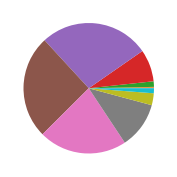

In [20]:
plt.figure(figsize = (3, 3))
plt.pie(df_train_gb_OverallQual['OverallQual']) # , labels=df_train_gb_OverallQual.index

plt.show()

## Remove GrLivArea outliers

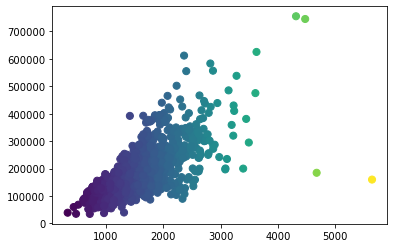

In [21]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'], c = df_train['GrLivArea'], s = 50);

In [22]:
df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index, inplace=True)

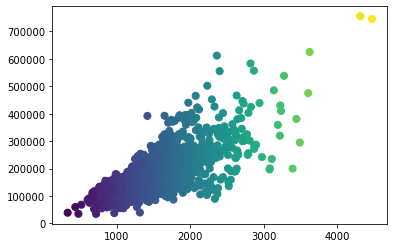

In [23]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'], c = df_train['GrLivArea'], s = 50);

In [24]:
df_train.shape

(1458, 80)

## Equilibrate YearBuilt

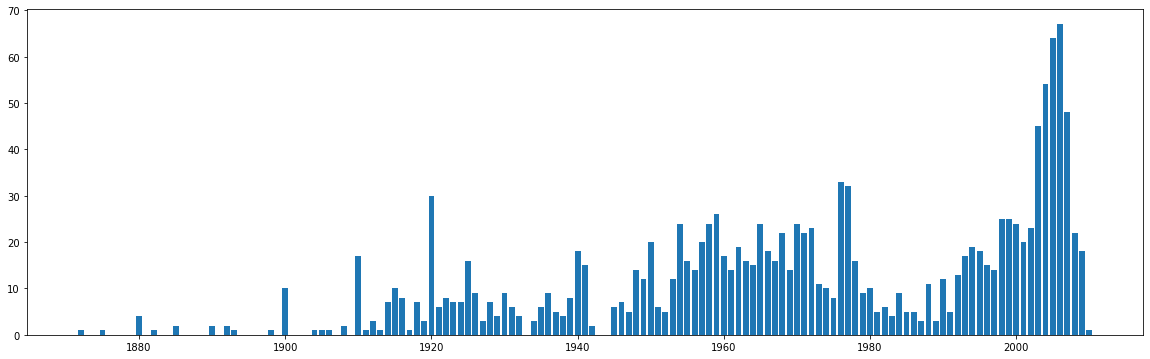

In [25]:
df_train_gb_YearBuilt =  df_train[['YearBuilt']].groupby(['YearBuilt'])[['YearBuilt']].count()

plt.figure(figsize=(20,6))
plt.bar(df_train_gb_YearBuilt.index, df_train_gb_YearBuilt['YearBuilt'], label = "YearBuilt");

In [26]:
YearBuilt_max_count = 70
df_train['YearBuilt'].unique()

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1920, 1966, 1959, 1994, 1954, 1953, 1955,
       1983, 1975, 1997, 1934, 1963, 1981, 1964, 1999, 1972, 1921, 1945,
       1982, 1998, 1956, 1948, 1910, 1995, 1991, 2009, 1950, 1961, 1977,
       1985, 1979, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905], dtype=int64)

In [27]:

for i in df_train['YearBuilt'].unique():
    c = df_train[df_train['YearBuilt'] == i]['YearBuilt'].count()
    
    
    while c < YearBuilt_max_count:
        
        row_index = random.randint(0, c-1)
        df_train = pd.concat([df_train, df_train[df_train['YearBuilt'] == i].iloc[[row_index]]])
        print(YearBuilt_max_count, c, i, row_index)
        c += 1


70 45 2003 44
70 46 2003 8
70 47 2003 40
70 48 2003 10
70 49 2003 3
70 50 2003 47
70 51 2003 25
70 52 2003 50
70 53 2003 32
70 54 2003 9
70 55 2003 8
70 56 2003 13
70 57 2003 51
70 58 2003 13
70 59 2003 38
70 60 2003 50
70 61 2003 39
70 62 2003 3
70 63 2003 15
70 64 2003 48
70 65 2003 21
70 66 2003 44
70 67 2003 19
70 68 2003 9
70 69 2003 66
70 33 1976 0
70 34 1976 5
70 35 1976 13
70 36 1976 14
70 37 1976 11
70 38 1976 8
70 39 1976 38
70 40 1976 13
70 41 1976 28
70 42 1976 19
70 43 1976 0
70 44 1976 16
70 45 1976 13
70 46 1976 42
70 47 1976 41
70 48 1976 13
70 49 1976 21
70 50 1976 45
70 51 1976 49
70 52 1976 0
70 53 1976 41
70 54 1976 3
70 55 1976 13
70 56 1976 35
70 57 1976 3
70 58 1976 47
70 59 1976 8
70 60 1976 6
70 61 1976 17
70 62 1976 3
70 63 1976 33
70 64 1976 10
70 65 1976 24
70 66 1976 26
70 67 1976 52
70 68 1976 38
70 69 1976 58
70 20 2001 6
70 21 2001 16
70 22 2001 11
70 23 2001 19
70 24 2001 18
70 25 2001 0
70 26 2001 12
70 27 2001 12
70 28 2001 18
70 29 2001 26
70 30 2001

70 54 1960 18
70 55 1960 20
70 56 1960 30
70 57 1960 3
70 58 1960 24
70 59 1960 21
70 60 1960 30
70 61 1960 45
70 62 1960 19
70 63 1960 56
70 64 1960 53
70 65 1960 45
70 66 1960 45
70 67 1960 9
70 68 1960 53
70 69 1960 53
70 4 1929 0
70 5 1929 4
70 6 1929 5
70 7 1929 4
70 8 1929 4
70 9 1929 7
70 10 1929 5
70 11 1929 10
70 12 1929 9
70 13 1929 8
70 14 1929 9
70 15 1929 13
70 16 1929 3
70 17 1929 1
70 18 1929 1
70 19 1929 8
70 20 1929 7
70 21 1929 13
70 22 1929 1
70 23 1929 20
70 24 1929 20
70 25 1929 12
70 26 1929 8
70 27 1929 17
70 28 1929 26
70 29 1929 24
70 30 1929 27
70 31 1929 4
70 32 1929 7
70 33 1929 10
70 34 1929 11
70 35 1929 9
70 36 1929 31
70 37 1929 11
70 38 1929 28
70 39 1929 7
70 40 1929 13
70 41 1929 30
70 42 1929 31
70 43 1929 41
70 44 1929 19
70 45 1929 21
70 46 1929 3
70 47 1929 15
70 48 1929 4
70 49 1929 28
70 50 1929 17
70 51 1929 31
70 52 1929 36
70 53 1929 8
70 54 1929 46
70 55 1929 17
70 56 1929 17
70 57 1929 50
70 58 1929 41
70 59 1929 14
70 60 1929 15
70 61 1929

70 43 1920 33
70 44 1920 26
70 45 1920 6
70 46 1920 33
70 47 1920 10
70 48 1920 32
70 49 1920 23
70 50 1920 25
70 51 1920 34
70 52 1920 48
70 53 1920 24
70 54 1920 47
70 55 1920 39
70 56 1920 52
70 57 1920 29
70 58 1920 50
70 59 1920 35
70 60 1920 51
70 61 1920 36
70 62 1920 1
70 63 1920 4
70 64 1920 5
70 65 1920 23
70 66 1920 57
70 67 1920 33
70 68 1920 3
70 69 1920 7
70 18 1966 13
70 19 1966 17
70 20 1966 18
70 21 1966 8
70 22 1966 1
70 23 1966 8
70 24 1966 5
70 25 1966 13
70 26 1966 7
70 27 1966 22
70 28 1966 4
70 29 1966 8
70 30 1966 27
70 31 1966 15
70 32 1966 20
70 33 1966 14
70 34 1966 9
70 35 1966 19
70 36 1966 34
70 37 1966 17
70 38 1966 12
70 39 1966 9
70 40 1966 26
70 41 1966 27
70 42 1966 38
70 43 1966 29
70 44 1966 41
70 45 1966 10
70 46 1966 31
70 47 1966 19
70 48 1966 1
70 49 1966 31
70 50 1966 31
70 51 1966 5
70 52 1966 26
70 53 1966 28
70 54 1966 20
70 55 1966 17
70 56 1966 27
70 57 1966 15
70 58 1966 25
70 59 1966 1
70 60 1966 56
70 61 1966 11
70 62 1966 43
70 63 1966

70 42 1963 35
70 43 1963 23
70 44 1963 0
70 45 1963 29
70 46 1963 34
70 47 1963 11
70 48 1963 25
70 49 1963 10
70 50 1963 45
70 51 1963 14
70 52 1963 40
70 53 1963 36
70 54 1963 32
70 55 1963 2
70 56 1963 25
70 57 1963 34
70 58 1963 21
70 59 1963 20
70 60 1963 0
70 61 1963 40
70 62 1963 61
70 63 1963 1
70 64 1963 2
70 65 1963 31
70 66 1963 13
70 67 1963 49
70 68 1963 6
70 69 1963 68
70 5 1981 3
70 6 1981 3
70 7 1981 4
70 8 1981 5
70 9 1981 5
70 10 1981 2
70 11 1981 2
70 12 1981 2
70 13 1981 2
70 14 1981 12
70 15 1981 0
70 16 1981 14
70 17 1981 1
70 18 1981 10
70 19 1981 16
70 20 1981 1
70 21 1981 0
70 22 1981 5
70 23 1981 2
70 24 1981 19
70 25 1981 14
70 26 1981 9
70 27 1981 13
70 28 1981 23
70 29 1981 15
70 30 1981 4
70 31 1981 26
70 32 1981 21
70 33 1981 32
70 34 1981 7
70 35 1981 17
70 36 1981 7
70 37 1981 16
70 38 1981 29
70 39 1981 19
70 40 1981 22
70 41 1981 31
70 42 1981 11
70 43 1981 14
70 44 1981 28
70 45 1981 13
70 46 1981 6
70 47 1981 6
70 48 1981 43
70 49 1981 44
70 50 1981

70 42 1910 27
70 43 1910 24
70 44 1910 9
70 45 1910 13
70 46 1910 33
70 47 1910 5
70 48 1910 15
70 49 1910 28
70 50 1910 14
70 51 1910 40
70 52 1910 7
70 53 1910 52
70 54 1910 29
70 55 1910 35
70 56 1910 13
70 57 1910 34
70 58 1910 57
70 59 1910 39
70 60 1910 0
70 61 1910 27
70 62 1910 7
70 63 1910 33
70 64 1910 63
70 65 1910 7
70 66 1910 9
70 67 1910 28
70 68 1910 1
70 69 1910 42
70 18 1995 16
70 19 1995 17
70 20 1995 14
70 21 1995 4
70 22 1995 9
70 23 1995 19
70 24 1995 0
70 25 1995 11
70 26 1995 9
70 27 1995 11
70 28 1995 11
70 29 1995 8
70 30 1995 8
70 31 1995 9
70 32 1995 22
70 33 1995 21
70 34 1995 8
70 35 1995 34
70 36 1995 19
70 37 1995 35
70 38 1995 22
70 39 1995 26
70 40 1995 2
70 41 1995 6
70 42 1995 31
70 43 1995 5
70 44 1995 9
70 45 1995 11
70 46 1995 29
70 47 1995 16
70 48 1995 47
70 49 1995 22
70 50 1995 12
70 51 1995 17
70 52 1995 1
70 53 1995 28
70 54 1995 25
70 55 1995 41
70 56 1995 52
70 57 1995 55
70 58 1995 25
70 59 1995 39
70 60 1995 27
70 61 1995 3
70 62 1995 1
7

70 24 1990 5
70 25 1990 17
70 26 1990 12
70 27 1990 20
70 28 1990 10
70 29 1990 28
70 30 1990 27
70 31 1990 13
70 32 1990 1
70 33 1990 31
70 34 1990 27
70 35 1990 10
70 36 1990 32
70 37 1990 32
70 38 1990 26
70 39 1990 8
70 40 1990 21
70 41 1990 30
70 42 1990 1
70 43 1990 19
70 44 1990 0
70 45 1990 29
70 46 1990 41
70 47 1990 38
70 48 1990 23
70 49 1990 41
70 50 1990 5
70 51 1990 26
70 52 1990 1
70 53 1990 26
70 54 1990 23
70 55 1990 14
70 56 1990 22
70 57 1990 15
70 58 1990 36
70 59 1990 9
70 60 1990 53
70 61 1990 25
70 62 1990 57
70 63 1990 33
70 64 1990 55
70 65 1990 23
70 66 1990 26
70 67 1990 59
70 68 1990 59
70 69 1990 25
70 14 1969 3
70 15 1969 14
70 16 1969 0
70 17 1969 15
70 18 1969 8
70 19 1969 9
70 20 1969 17
70 21 1969 15
70 22 1969 8
70 23 1969 20
70 24 1969 15
70 25 1969 1
70 26 1969 15
70 27 1969 26
70 28 1969 13
70 29 1969 17
70 30 1969 26
70 31 1969 22
70 32 1969 13
70 33 1969 1
70 34 1969 0
70 35 1969 4
70 36 1969 12
70 37 1969 25
70 38 1969 17
70 39 1969 20
70 40 196

70 41 1926 26
70 42 1926 8
70 43 1926 36
70 44 1926 8
70 45 1926 9
70 46 1926 38
70 47 1926 13
70 48 1926 30
70 49 1926 27
70 50 1926 16
70 51 1926 32
70 52 1926 44
70 53 1926 23
70 54 1926 17
70 55 1926 5
70 56 1926 16
70 57 1926 23
70 58 1926 23
70 59 1926 57
70 60 1926 18
70 61 1926 10
70 62 1926 42
70 63 1926 39
70 64 1926 52
70 65 1926 44
70 66 1926 59
70 67 1926 32
70 68 1926 45
70 69 1926 7
70 18 1940 7
70 19 1940 2
70 20 1940 12
70 21 1940 11
70 22 1940 9
70 23 1940 18
70 24 1940 17
70 25 1940 2
70 26 1940 19
70 27 1940 4
70 28 1940 4
70 29 1940 3
70 30 1940 18
70 31 1940 25
70 32 1940 31
70 33 1940 18
70 34 1940 24
70 35 1940 21
70 36 1940 16
70 37 1940 21
70 38 1940 11
70 39 1940 18
70 40 1940 6
70 41 1940 33
70 42 1940 23
70 43 1940 33
70 44 1940 3
70 45 1940 26
70 46 1940 1
70 47 1940 8
70 48 1940 45
70 49 1940 38
70 50 1940 7
70 51 1940 25
70 52 1940 34
70 53 1940 9
70 54 1940 44
70 55 1940 8
70 56 1940 44
70 57 1940 32
70 58 1940 8
70 59 1940 47
70 60 1940 46
70 61 1940 5

70 42 1918 35
70 43 1918 21
70 44 1918 33
70 45 1918 13
70 46 1918 8
70 47 1918 37
70 48 1918 29
70 49 1918 19
70 50 1918 15
70 51 1918 47
70 52 1918 27
70 53 1918 24
70 54 1918 19
70 55 1918 16
70 56 1918 54
70 57 1918 5
70 58 1918 0
70 59 1918 14
70 60 1918 54
70 61 1918 51
70 62 1918 24
70 63 1918 13
70 64 1918 12
70 65 1918 23
70 66 1918 34
70 67 1918 2
70 68 1918 66
70 69 1918 51
70 3 1912 0
70 4 1912 2
70 5 1912 0
70 6 1912 0
70 7 1912 4
70 8 1912 0
70 9 1912 3
70 10 1912 3
70 11 1912 9
70 12 1912 1
70 13 1912 3
70 14 1912 6
70 15 1912 5
70 16 1912 4
70 17 1912 13
70 18 1912 2
70 19 1912 13
70 20 1912 5
70 21 1912 17
70 22 1912 21
70 23 1912 17
70 24 1912 21
70 25 1912 2
70 26 1912 12
70 27 1912 12
70 28 1912 20
70 29 1912 20
70 30 1912 2
70 31 1912 25
70 32 1912 31
70 33 1912 2
70 34 1912 32
70 35 1912 33
70 36 1912 7
70 37 1912 31
70 38 1912 3
70 39 1912 10
70 40 1912 18
70 41 1912 4
70 42 1912 4
70 43 1912 16
70 44 1912 40
70 45 1912 11
70 46 1912 24
70 47 1912 1
70 48 1912 16

70 40 1928 28
70 41 1928 23
70 42 1928 18
70 43 1928 27
70 44 1928 20
70 45 1928 29
70 46 1928 18
70 47 1928 39
70 48 1928 8
70 49 1928 32
70 50 1928 1
70 51 1928 47
70 52 1928 22
70 53 1928 40
70 54 1928 9
70 55 1928 14
70 56 1928 33
70 57 1928 18
70 58 1928 16
70 59 1928 47
70 60 1928 28
70 61 1928 58
70 62 1928 21
70 63 1928 29
70 64 1928 17
70 65 1928 59
70 66 1928 22
70 67 1928 38
70 68 1928 12
70 69 1928 29
70 16 1978 12
70 17 1978 2
70 18 1978 17
70 19 1978 0
70 20 1978 11
70 21 1978 8
70 22 1978 9
70 23 1978 16
70 24 1978 5
70 25 1978 24
70 26 1978 23
70 27 1978 14
70 28 1978 12
70 29 1978 1
70 30 1978 6
70 31 1978 11
70 32 1978 19
70 33 1978 29
70 34 1978 9
70 35 1978 6
70 36 1978 5
70 37 1978 7
70 38 1978 11
70 39 1978 5
70 40 1978 25
70 41 1978 37
70 42 1978 33
70 43 1978 21
70 44 1978 7
70 45 1978 32
70 46 1978 2
70 47 1978 22
70 48 1978 36
70 49 1978 25
70 50 1978 39
70 51 1978 12
70 52 1978 23
70 53 1978 9
70 54 1978 18
70 55 1978 17
70 56 1978 0
70 57 1978 19
70 58 1978 

70 14 1974 11
70 15 1974 12
70 16 1974 11
70 17 1974 10
70 18 1974 4
70 19 1974 14
70 20 1974 7
70 21 1974 13
70 22 1974 14
70 23 1974 19
70 24 1974 7
70 25 1974 10
70 26 1974 1
70 27 1974 9
70 28 1974 12
70 29 1974 12
70 30 1974 0
70 31 1974 27
70 32 1974 6
70 33 1974 25
70 34 1974 23
70 35 1974 31
70 36 1974 11
70 37 1974 7
70 38 1974 12
70 39 1974 11
70 40 1974 16
70 41 1974 0
70 42 1974 40
70 43 1974 13
70 44 1974 13
70 45 1974 12
70 46 1974 27
70 47 1974 41
70 48 1974 37
70 49 1974 8
70 50 1974 14
70 51 1974 17
70 52 1974 38
70 53 1974 33
70 54 1974 1
70 55 1974 14
70 56 1974 23
70 57 1974 8
70 58 1974 24
70 59 1974 16
70 60 1974 45
70 61 1974 30
70 62 1974 27
70 63 1974 20
70 64 1974 56
70 65 1974 10
70 66 1974 35
70 67 1974 26
70 68 1974 27
70 69 1974 23
70 1 1893 0
70 2 1893 0
70 3 1893 1
70 4 1893 1
70 5 1893 1
70 6 1893 5
70 7 1893 3
70 8 1893 0
70 9 1893 0
70 10 1893 6
70 11 1893 8
70 12 1893 3
70 13 1893 12
70 14 1893 7
70 15 1893 3
70 16 1893 15
70 17 1893 8
70 18 1893 13


70 19 1911 9
70 20 1911 14
70 21 1911 0
70 22 1911 16
70 23 1911 1
70 24 1911 20
70 25 1911 15
70 26 1911 9
70 27 1911 7
70 28 1911 17
70 29 1911 18
70 30 1911 2
70 31 1911 15
70 32 1911 30
70 33 1911 19
70 34 1911 29
70 35 1911 21
70 36 1911 18
70 37 1911 15
70 38 1911 7
70 39 1911 24
70 40 1911 24
70 41 1911 19
70 42 1911 24
70 43 1911 18
70 44 1911 38
70 45 1911 5
70 46 1911 40
70 47 1911 9
70 48 1911 8
70 49 1911 21
70 50 1911 38
70 51 1911 22
70 52 1911 45
70 53 1911 20
70 54 1911 21
70 55 1911 10
70 56 1911 39
70 57 1911 27
70 58 1911 55
70 59 1911 26
70 60 1911 50
70 61 1911 52
70 62 1911 24
70 63 1911 56
70 64 1911 47
70 65 1911 58
70 66 1911 56
70 67 1911 32
70 68 1911 52
70 69 1911 6
70 1 1917 0
70 2 1917 1
70 3 1917 1
70 4 1917 2
70 5 1917 4
70 6 1917 3
70 7 1917 6
70 8 1917 1
70 9 1917 2
70 10 1917 7
70 11 1917 4
70 12 1917 9
70 13 1917 5
70 14 1917 8
70 15 1917 13
70 16 1917 6
70 17 1917 2
70 18 1917 16
70 19 1917 1
70 20 1917 7
70 21 1917 2
70 22 1917 15
70 23 1917 4
70 2

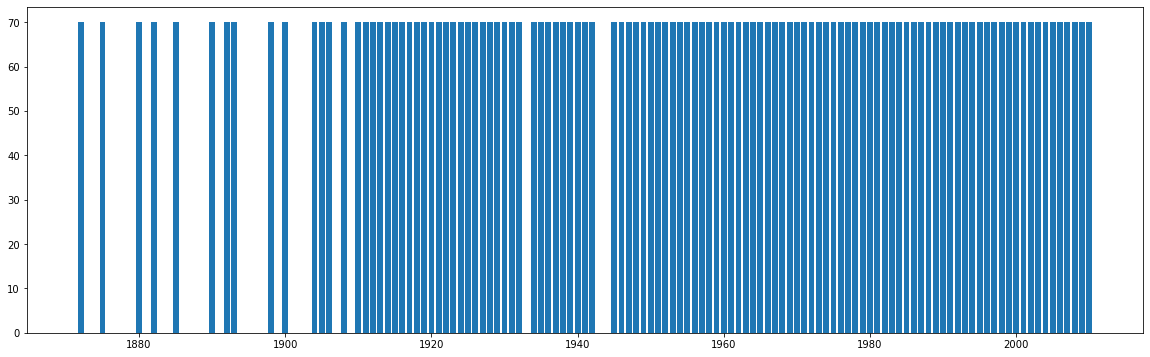

In [28]:
df_train_gb_YearBuilt =  df_train[['YearBuilt']].groupby(['YearBuilt'])[['YearBuilt']].count()

plt.figure(figsize=(20,6))
plt.bar(df_train_gb_YearBuilt.index, df_train_gb_YearBuilt['YearBuilt'], label = "YearBuilt");

## Equilibrate OverallQual

<BarContainer object of 10 artists>

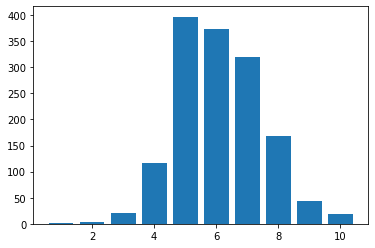

In [29]:
plt.bar(range(1, len(df_train_gb_OverallQual)+1), df_train_gb_OverallQual['OverallQual'], label = "OverallQual")

In [30]:
OverallQual_5_count = df_train[df_train['OverallQual'] == 5]['OverallQual'].count()

In [31]:

'''
for i in [1, 2, 3, 4, 6, 7, 8, 9, 10]:
    c = df_train[df_train['OverallQual'] == i]['OverallQual'].count()
    
    
    while c < OverallQual_5_count:
        
        row_index = random.randint(0, c-1)
        df_train = pd.concat([df_train, df_train[df_train['OverallQual'] == i].iloc[[row_index]]])
        print(OverallQual_5_count, c, i, row_index)
        c += 1
'''

"\nfor i in [1, 2, 3, 4, 6, 7, 8, 9, 10]:\n    c = df_train[df_train['OverallQual'] == i]['OverallQual'].count()\n    \n    \n    while c < OverallQual_5_count:\n        \n        row_index = random.randint(0, c-1)\n        df_train = pd.concat([df_train, df_train[df_train['OverallQual'] == i].iloc[[row_index]]])\n        print(OverallQual_5_count, c, i, row_index)\n        c += 1\n"

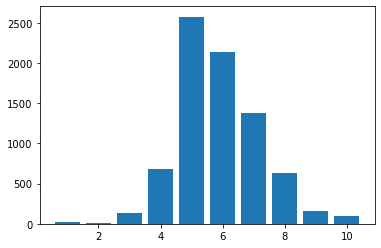

In [32]:
df_train_gb_OverallQual =  df_train[['OverallQual']].groupby(['OverallQual'])[['OverallQual']].count()

plt.bar(range(1, len(df_train_gb_OverallQual)+1), df_train_gb_OverallQual['OverallQual'], label = "OverallQual");

# ==========================================================

#### separate target and data

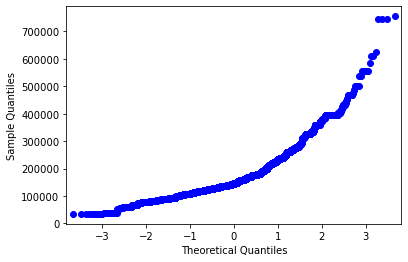

In [33]:
import statsmodels.api as sm

sm.qqplot(df_train['SalePrice'])
plt.show()

In [34]:
# Handling skewed data
# centrer la distribution de la cible
target = np.log1p(df_train['SalePrice'])
data = df_train.drop('SalePrice', axis = 1)

print(data.shape, target.shape)

(7840, 79) (7840,)


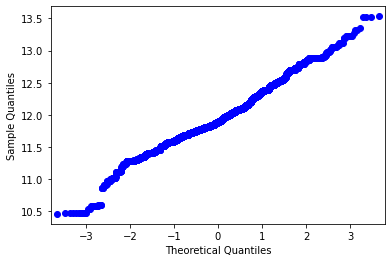

In [35]:
sm.qqplot(target)
plt.show()

### Scale data

In [36]:
#scaler = preprocessing.StandardScaler().fit(data)
scaler = preprocessing.MinMaxScaler().fit(data)
data[data.columns] = pd.DataFrame(scaler.transform(data), index=data.index)

data.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,MSZoning,LotShape,BsmtExposure,HeatingQC,GarageType,FireplaceQu,GarageFinish,KitchenQual,BsmtQual,ExterQual
0,0.666667,0.332207,0.50,0.394245,0.266999,0.180373,0.666667,0.500000,0.949275,0.883333,...,0.75,1.0,0.75,0.0,0.166667,1.0,0.333333,0.666667,0.50,0.666667
1,0.555556,0.224046,0.50,0.330935,0.393637,0.320663,0.666667,0.333333,0.753623,0.433333,...,0.75,1.0,0.25,0.0,0.166667,0.8,0.333333,1.000000,0.50,1.000000
2,0.666667,0.350555,0.50,0.437410,0.286962,0.202488,0.666667,0.333333,0.934783,0.866667,...,0.75,0.0,0.50,0.0,0.166667,0.8,0.333333,0.666667,0.50,0.666667
3,0.666667,0.333897,0.75,0.461871,0.235808,0.216655,0.333333,0.416667,0.311594,0.333333,...,0.75,0.0,0.75,0.5,0.833333,0.4,0.666667,0.666667,0.75,1.000000
4,0.777778,0.450024,0.75,0.601439,0.357143,0.280235,0.666667,0.583333,0.927536,0.833333,...,0.75,0.0,0.00,0.0,0.166667,0.8,0.333333,0.666667,0.50,0.666667


# XGBRegressor

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state = 66) 

In [38]:
#xgbr_gridSearchCV_best_params(learning_rate = [0.02, 0.03, 0.05], n_estimators = [4500, 4000], subsample=[1])
#xgbr_gridSearchCV_best_params(max_depth = [11,12,13])

In [39]:
result = XGBRegressor_fit( 
        colsample_bytree=0.5, 
        learning_rate=0.02, 
        max_depth=11, 
        min_child_weight=1, 
        n_estimators=4500,
        subsample=1, 
        gamma = 1,
        verbose = True)

[0]	validation_0-rmse:11.22228
[1]	validation_0-rmse:10.99800
[2]	validation_0-rmse:10.77820
[3]	validation_0-rmse:10.56281
[4]	validation_0-rmse:10.35172
[5]	validation_0-rmse:10.14485
[6]	validation_0-rmse:9.94213
[7]	validation_0-rmse:9.74346
[8]	validation_0-rmse:9.54877
[9]	validation_0-rmse:9.35798
[10]	validation_0-rmse:9.17094
[11]	validation_0-rmse:8.98770
[12]	validation_0-rmse:8.80806
[13]	validation_0-rmse:8.63213
[14]	validation_0-rmse:8.45961
[15]	validation_0-rmse:8.29068
[16]	validation_0-rmse:8.12515
[17]	validation_0-rmse:7.96292
[18]	validation_0-rmse:7.80381
[19]	validation_0-rmse:7.64786
[20]	validation_0-rmse:7.49508
[21]	validation_0-rmse:7.34543
[22]	validation_0-rmse:7.19876
[23]	validation_0-rmse:7.05505
[24]	validation_0-rmse:6.91409
[25]	validation_0-rmse:6.77598
[26]	validation_0-rmse:6.64069
[27]	validation_0-rmse:6.50813
[28]	validation_0-rmse:6.37817
[29]	validation_0-rmse:6.25084
[30]	validation_0-rmse:6.12601
[31]	validation_0-rmse:6.00383
[32]	validat

[260]	validation_0-rmse:0.07879
[261]	validation_0-rmse:0.07774
[262]	validation_0-rmse:0.07671
[263]	validation_0-rmse:0.07571
[264]	validation_0-rmse:0.07476
[265]	validation_0-rmse:0.07379
[266]	validation_0-rmse:0.07284
[267]	validation_0-rmse:0.07193
[268]	validation_0-rmse:0.07106
[269]	validation_0-rmse:0.07020
[270]	validation_0-rmse:0.06935
[271]	validation_0-rmse:0.06854
[272]	validation_0-rmse:0.06773
[273]	validation_0-rmse:0.06694
[274]	validation_0-rmse:0.06618
[275]	validation_0-rmse:0.06544
[276]	validation_0-rmse:0.06473
[277]	validation_0-rmse:0.06403
[278]	validation_0-rmse:0.06334
[279]	validation_0-rmse:0.06268
[280]	validation_0-rmse:0.06203
[281]	validation_0-rmse:0.06138
[282]	validation_0-rmse:0.06078
[283]	validation_0-rmse:0.06015
[284]	validation_0-rmse:0.05955
[285]	validation_0-rmse:0.05897
[286]	validation_0-rmse:0.05843
[287]	validation_0-rmse:0.05787
[288]	validation_0-rmse:0.05733
[289]	validation_0-rmse:0.05683
[290]	validation_0-rmse:0.05635
[291]	va

[517]	validation_0-rmse:0.03749
[518]	validation_0-rmse:0.03748
[519]	validation_0-rmse:0.03748
[520]	validation_0-rmse:0.03747
[521]	validation_0-rmse:0.03746
[522]	validation_0-rmse:0.03745
[523]	validation_0-rmse:0.03745
[524]	validation_0-rmse:0.03744
[525]	validation_0-rmse:0.03744
[526]	validation_0-rmse:0.03743
[527]	validation_0-rmse:0.03742
[528]	validation_0-rmse:0.03742
[529]	validation_0-rmse:0.03741
[530]	validation_0-rmse:0.03741
[531]	validation_0-rmse:0.03740
[532]	validation_0-rmse:0.03739
[533]	validation_0-rmse:0.03739
[534]	validation_0-rmse:0.03738
[535]	validation_0-rmse:0.03737
[536]	validation_0-rmse:0.03737
[537]	validation_0-rmse:0.03736
[538]	validation_0-rmse:0.03735
[539]	validation_0-rmse:0.03734
[540]	validation_0-rmse:0.03734
[541]	validation_0-rmse:0.03733
[542]	validation_0-rmse:0.03732
[543]	validation_0-rmse:0.03732
[544]	validation_0-rmse:0.03731
[545]	validation_0-rmse:0.03731
[546]	validation_0-rmse:0.03731
[547]	validation_0-rmse:0.03731
[548]	va

[773]	validation_0-rmse:0.03673
[774]	validation_0-rmse:0.03673
[775]	validation_0-rmse:0.03672
[776]	validation_0-rmse:0.03672
[777]	validation_0-rmse:0.03672
[778]	validation_0-rmse:0.03672
[779]	validation_0-rmse:0.03672
[780]	validation_0-rmse:0.03671
[781]	validation_0-rmse:0.03671
[782]	validation_0-rmse:0.03671
[783]	validation_0-rmse:0.03671
[784]	validation_0-rmse:0.03671
[785]	validation_0-rmse:0.03671
[786]	validation_0-rmse:0.03671
[787]	validation_0-rmse:0.03671
[788]	validation_0-rmse:0.03671
[789]	validation_0-rmse:0.03671
[790]	validation_0-rmse:0.03671
[791]	validation_0-rmse:0.03671
[792]	validation_0-rmse:0.03671
[793]	validation_0-rmse:0.03671
[794]	validation_0-rmse:0.03671
[795]	validation_0-rmse:0.03670
[796]	validation_0-rmse:0.03670
[797]	validation_0-rmse:0.03670
[798]	validation_0-rmse:0.03670
[799]	validation_0-rmse:0.03670
[800]	validation_0-rmse:0.03670
[801]	validation_0-rmse:0.03670
[802]	validation_0-rmse:0.03670
[803]	validation_0-rmse:0.03670
[804]	va

[1029]	validation_0-rmse:0.03657
[1030]	validation_0-rmse:0.03657
[1031]	validation_0-rmse:0.03657
[1032]	validation_0-rmse:0.03657
[1033]	validation_0-rmse:0.03657
[1034]	validation_0-rmse:0.03657
[1035]	validation_0-rmse:0.03657
[1036]	validation_0-rmse:0.03657
[1037]	validation_0-rmse:0.03657
[1038]	validation_0-rmse:0.03657
[1039]	validation_0-rmse:0.03657
[1040]	validation_0-rmse:0.03657
[1041]	validation_0-rmse:0.03657
[1042]	validation_0-rmse:0.03657
[1043]	validation_0-rmse:0.03657
[1044]	validation_0-rmse:0.03657
[1045]	validation_0-rmse:0.03657
[1046]	validation_0-rmse:0.03657
[1047]	validation_0-rmse:0.03657
[1048]	validation_0-rmse:0.03657
[1049]	validation_0-rmse:0.03657
[1050]	validation_0-rmse:0.03657
[1051]	validation_0-rmse:0.03657
[1052]	validation_0-rmse:0.03657
[1053]	validation_0-rmse:0.03657
[1054]	validation_0-rmse:0.03657
[1055]	validation_0-rmse:0.03657
[1056]	validation_0-rmse:0.03657
[1057]	validation_0-rmse:0.03656
[1058]	validation_0-rmse:0.03656
[1059]	val

In [40]:
result

{'xgb_r': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=11, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=4500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None),
 'rmse': 0.03655749810494407,
 'score_train': 0.9999949078700903,
 'score_test': 0.9913002146083854}

In [41]:
xgb_r = result['xgb_r']

In [42]:
len(X_train.columns)

79

In [43]:

pred = xgb_r.predict(scaler.transform(label_encode_to_int(df_test[data.columns])))

df_pred = pd.DataFrame(np.expm1(pred), columns=['SalePrice'])
df_pred.head()

,SalePrice
0,127017.812500
1,165033.890625
2,182810.515625
3,188285.953125
4,190806.515625


In [44]:
df_pred = df_test_Id.join(df_pred)
df_pred.to_csv('./submission/model_xgb_r_g00.csv', index=False)

### =========================================================================

https://vitalflux.com/keras-neural-network-for-regression-problem/?utm_content=cmp-true

https://towardsdatascience.com/regression-modelling-with-tensorflow-made-easy-train-your-first-model-in-10-minutes-497d829c7338
    
https://www.tensorflow.org/tutorials/load_data/pandas_dataframe?hl=fr

In [54]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

import math

In [61]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11247765764982554596
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2238919476
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16356572058619007013
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [111]:
X = data[data.columns[0:10]].values # [['OverallQual', 'GrLivArea', 'YearBuilt']]
y = target.values
X = X.reshape(X.shape[0], X.shape[1], 1)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
model = keras.Sequential([

    keras.layers.Conv1D(filters=2048, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2), # 
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256),    
    keras.layers.Dense(1)

])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [114]:
from keras.callbacks import EarlyStopping
 
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=True) 


Epoch 1/500
157/157 [==============================] - 2s 9ms/step - loss: 4.3864 - mae: 1.2177 - val_loss: 0.1045 - val_mae: 0.2518
Epoch 2/500
157/157 [==============================] - 1s 7ms/step - loss: 0.3509 - mae: 0.4709 - val_loss: 0.0477 - val_mae: 0.1758
Epoch 3/500
157/157 [==============================] - 1s 7ms/step - loss: 0.3638 - mae: 0.4794 - val_loss: 0.1307 - val_mae: 0.3275
Epoch 4/500
157/157 [==============================] - 1s 7ms/step - loss: 0.3738 - mae: 0.4893 - val_loss: 0.0581 - val_mae: 0.1998
Epoch 5/500
157/157 [==============================] - 1s 7ms/step - loss: 0.2995 - mae: 0.4350 - val_loss: 0.0821 - val_mae: 0.2383
Epoch 6/500
157/157 [==============================] - 1s 7ms/step - loss: 0.3408 - mae: 0.4678 - val_loss: 0.0382 - val_mae: 0.1450
Epoch 7/500
157/157 [==============================] - 1s 7ms/step - loss: 0.2777 - mae: 0.4161 - val_loss: 0.0601 - val_mae: 0.2067
Epoch 8/500
157/157 [==============================] - 1s 7ms/step - 

In [119]:
loss = model.evaluate(X_test, y_test)[0]
print("Mean squared error on test data: ", loss)
print("Root Mean squared error on test data: ", math.sqrt(loss))

49/49 [==============================] - 0s 8ms/step - loss: 0.0295 - mae: 0.1438
Mean squared error on test data:  0.029533637687563896
Root Mean squared error on test data:  0.17185353556899519


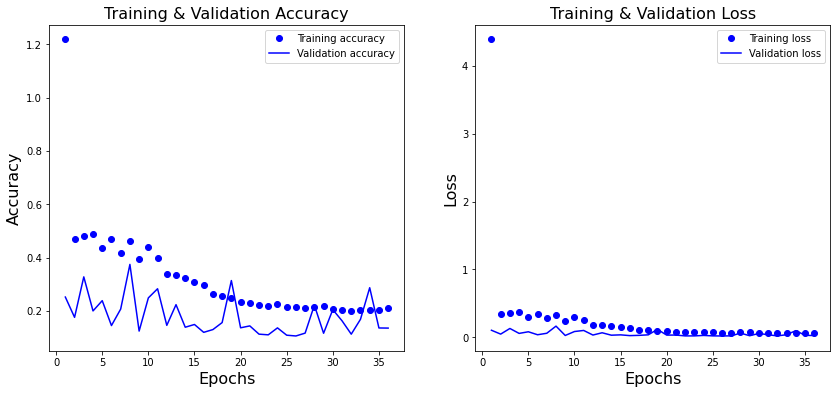

In [116]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['mae']
val_accuracy = history_dict['val_mae']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy (MAE) vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()